# Run pysindy on the wave equation calculations from conv kernel 1d wave eqn.ipynb

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint

## Load the data

In [2]:
sine = np.load('sine.npy')
gaussian = np.load('gaussianwave.npy')
verynoisy_gaussian = np.load('verynoisy_gaussianwave.npy')

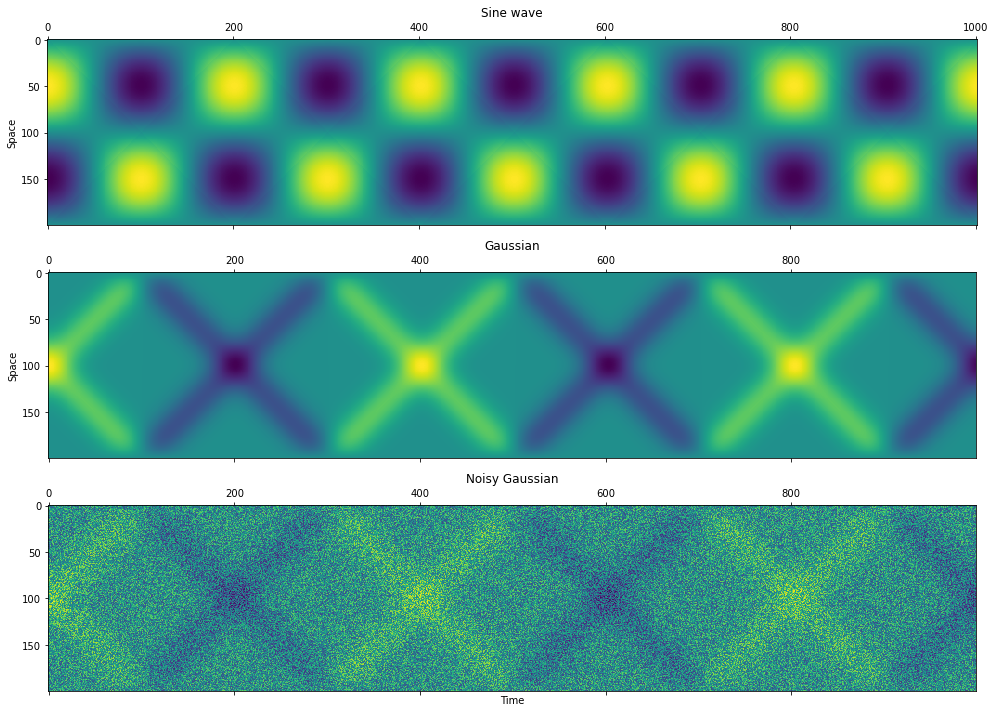

In [3]:
f, ax = plt.subplots(3,1, figsize=(30,10))

ax[0].matshow(sine.T)
ax[0].set_title('Sine wave')
ax[0].set_ylabel('Space')

ax[1].matshow(gaussian.T)
ax[1].set_title('Gaussian')
ax[1].set_ylabel('Space')

ax[2].matshow(verynoisy_gaussian.T)
ax[2].set_title('Noisy Gaussian')
ax[2].set_xlabel('Time')

plt.tight_layout()
plt.show()

## Proper Orthogonal Decomposition

First step is Proper Orthogonal Decomposition of the signal using SVD, in order to reduce the system to a lower dimensional representation.  Right now, the dimension of the solution (NOT the dimension of the wave equation) is $N * T$ where $N$ is the number of spatial discretization points, and $T$ is the number of timesteps.  In our systems above, the total dimension is $200 * 1000 = 2e5$.

Proper Orthogonal Decomposition is very PCA. In fact, one of the algorithms used for calculating the PCA of a dataset is also used for POD, that is, the singular value decomposition, SVD. 

SVD factors a matrix, $X$, into three matrices:

$ X = USV^T $

where $U$ and $V$ are matrices whose columns, in the case of POD, represent temporal and spatial basis vectors, respectively, also called modes. $S$ is a diagonal matrix of coefficients that indicates how much each basis vector contributes to $X$. With SVD, these coefficients are sorted in decreasing value, therefore the first basis vector is the most representative, the second is second most, etc. For systems that have structure, the first few 


In [4]:
u, s, vh = np.linalg.svd(sine)

## Power of the components

Plotted below are the normalized values of S for the solution of the wave equation with a sinusoidal initial condition.  You can see the the first value of S, and therefore the first basis vectors, represent nearly 100% of the signal (in a certain sense of the phrase).

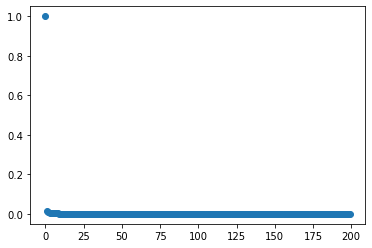

In [5]:
plt.plot(s/np.max(s), 'o')

## A single component has the vast majority of the power

Plot of the first 3 modes of the POD of the solution to the 1D wave equation with sinusoidal initial conditions.

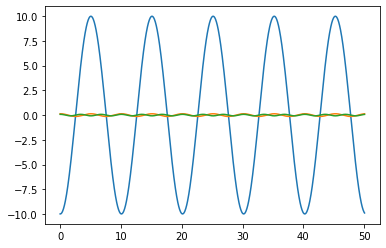

In [6]:
dt = 0.05
t = np.arange(0, dt*1002, dt)

plt.plot(t,u[...,0:3]@np.diag(s[0:3]))

Reconstruction of the solution from the first mode only.

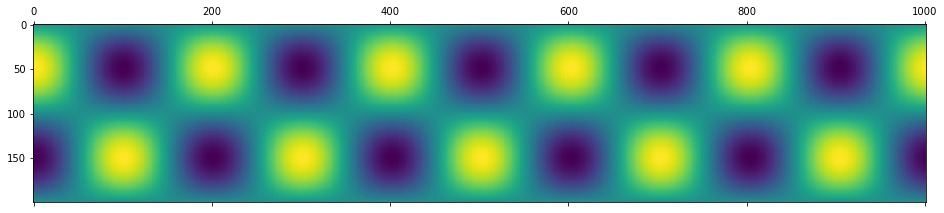

In [7]:
recon = (s[:1]*u[:,:1]@vh[:1,:]).T
plt.matshow(recon)

Mean squared error of the reconstructed matrix with the original solution matrix is on order of $10^{-4}$. Pretty good!!

In [8]:
((sine.T - recon)**2).mean()

9.034439e-05

In [9]:
## Now that the data matrix is decomposed into 

In [10]:
import pysindy as ps


In [11]:
poly_order = 3
threshold = 0.01
dt = 0.05

t = np.arange(0, dt*1002, dt)
u_train = np.concatenate((u[:,:2], t[:,np.newaxis]), axis=1)

polymodel = ps.SINDy(
    optimizer=ps.STLSQ(threshold=threshold, max_iter=1000),
    feature_library=ps.PolynomialLibrary(degree=poly_order),
    feature_names=['u1', 'u2', 't']
)

polymodel.fit(u_train, t)
polymodel.print()

u1' = 0.000
u2' = 2.751 u1 u2 + -0.110 u1 u2 t + 0.023 u2^2 t
t' = 1.000 1


/Users/nate/opt/anaconda3/envs/pysindy/lib/python3.7/site-packages/pysindy/optimizers/stlsq.py:153: UserWarning: Sparsity parameter is too big (0.01) and eliminated all coefficients
  "coefficients".format(self.threshold)


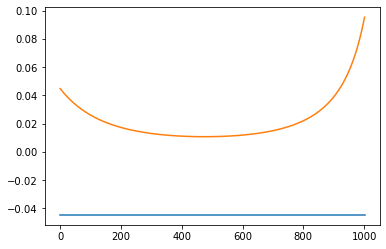

In [12]:
u1_sim, u2_sim, t_sim = polymodel.simulate([u[0,0], u[0,1], 0], t).T
plt.plot(u1_sim)
plt.plot(u2_sim)

In [13]:
threshold = 0.1

t = np.arange(0, dt*1002, dt)

fouriermodel = ps.SINDy(
    optimizer=ps.STLSQ(threshold=threshold, max_iter=1000000),
    feature_library=ps.FourierLibrary(n_frequencies=3),
    feature_names=['u1', 'u2', 't']
)

fouriermodel.fit(u_train, t)
fouriermodel.print()

u1' = 0.000
u2' = 0.000
t' = 0.759 cos(1 u1) + 0.741 cos(1 u2) + -0.304 cos(2 u1) + -0.297 cos(2 u2) + 0.051 cos(3 u1) + 0.049 cos(3 u2)


/Users/nate/opt/anaconda3/envs/pysindy/lib/python3.7/site-packages/pysindy/optimizers/stlsq.py:153: UserWarning: Sparsity parameter is too big (0.1) and eliminated all coefficients
  "coefficients".format(self.threshold)


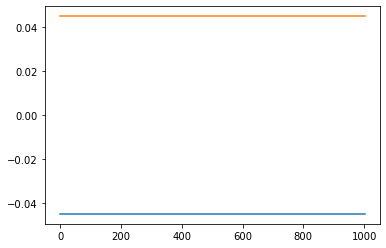

In [14]:
u1_sim, u2_sim, t_sim = fouriermodel.simulate([u[0,0], u[0,1], 0], t).T
plt.plot(u1_sim)
plt.plot(u2_sim)


In [15]:
fouriermodel.simulate([u[0,0], u[0,1], 0], t)

array([[-4.47372794e-02,  4.47396189e-02,  0.00000000e+00],
       [-4.47372794e-02,  4.47396189e-02,  5.00000000e-02],
       [-4.47372794e-02,  4.47396189e-02,  1.00000000e-01],
       ...,
       [-4.47372794e-02,  4.47396189e-02,  4.99500000e+01],
       [-4.47372794e-02,  4.47396189e-02,  5.00000000e+01],
       [-4.47372794e-02,  4.47396189e-02,  5.00500000e+01]])

## That's crap

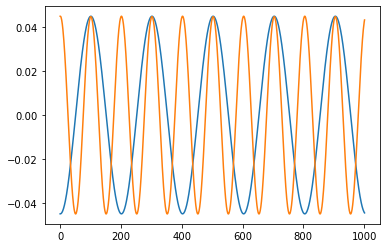

In [16]:
plt.plot(u[:,:2])

In [17]:
ut = ps.FiniteDifference()._differentiate(u[:,:2], t)

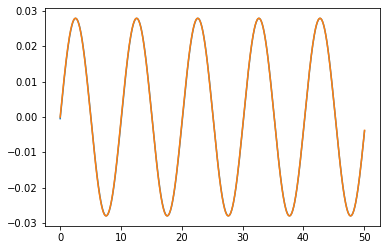

In [18]:
plt.plot(t,ut[:,0])
plt.plot(t, 0.028*np.sin(t/1.6))

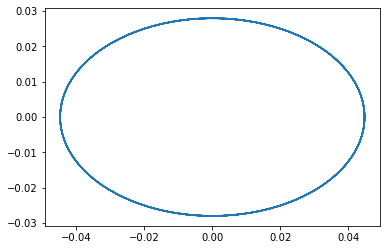

In [19]:
plt.plot(u[:,0], ut[:,0])

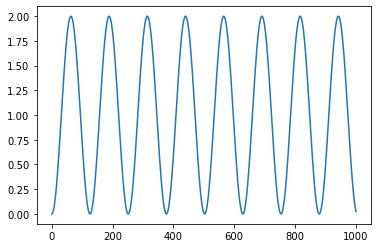

In [20]:
def f(x,t):
    return np.sin(t)

plt.plot(odeint(f, y0=0, t=t))

## Let's try the Gaussian wave init cond

You can see from the plot of the singular values and modes functions below that 4 modes from the POD are needed to adequately reconstruct the signal

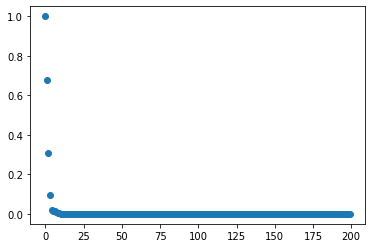

In [48]:
u_g, s_g, vh_g = np.linalg.svd(gaussian)
plt.plot(s/np.max(s), 'o')

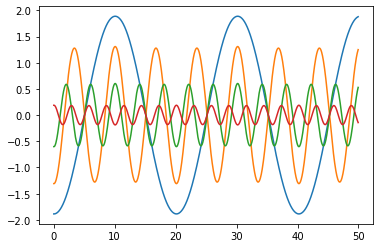

In [50]:
t = np.arange(0, dt*1000, dt)
plt.plot(t, u_g[:,:4]@np.diag(s[:4]))

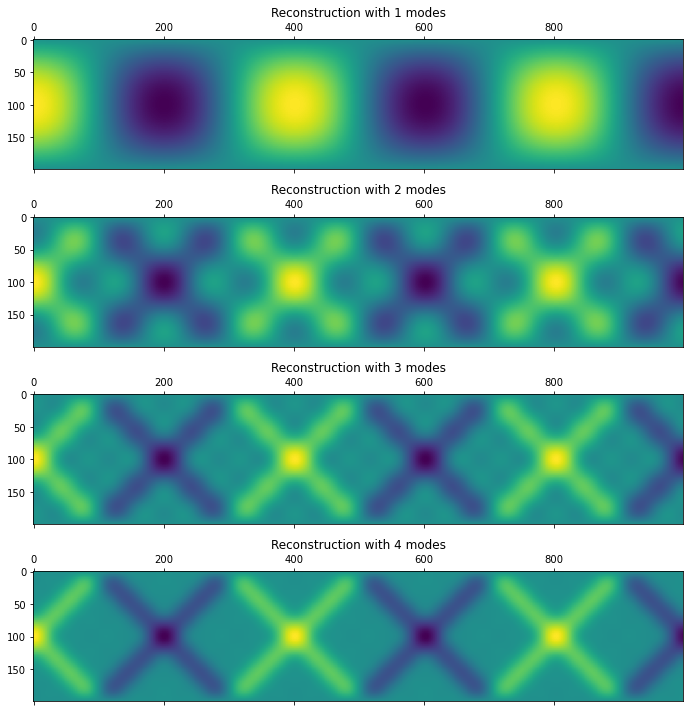

In [58]:
f, ax = plt.subplots(4,1,figsize=(20,10))
for ncpts in range(1,5):
    ax[ncpts-1].matshow((u_g[:,:ncpts]@np.diag(s[:ncpts])@vh_g[:ncpts,:]).T)
    ax[ncpts-1].set_title('Reconstruction with {} modes'.format(ncpts))
    
plt.tight_layout()

## Attempt SINDy model

u1' = 0.002
u2' = 0.131 u1^2 t + -0.001
u3' = 0.210 u1 u2 t + -0.166 u2^2 t + 0.006
t' = 1.000


/Users/nate/opt/anaconda3/envs/pysindy/lib/python3.7/site-packages/pysindy/optimizers/stlsq.py:153: UserWarning: Sparsity parameter is too big (0.11) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/nate/opt/anaconda3/envs/pysindy/lib/python3.7/site-packages/pysindy/optimizers/stlsq.py:153: UserWarning: Sparsity parameter is too big (0.11) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/nate/opt/anaconda3/envs/pysindy/lib/python3.7/site-packages/pysindy/optimizers/stlsq.py:153: UserWarning: Sparsity parameter is too big (0.11) and eliminated all coefficients
  "coefficients".format(self.threshold)


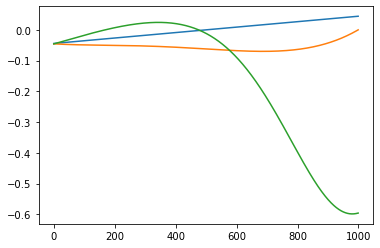

In [59]:
poly_order = 3
threshold = 0.11

t = np.arange(0, dt*1000, dt)
u_g_train = np.concatenate((u_g[:,:3], t[:,np.newaxis]), axis=1)

polymodel_g = ps.SINDy(
    optimizer=ps.STLSQ(threshold=threshold, max_iter=1000, fit_intercept=True),
    feature_library=ps.PolynomialLibrary(degree=poly_order),
    feature_names=['u1', 'u2', 'u3', 't']
)

polymodel_g.fit(u_g_train, t)
polymodel_g.print()

u1_g_sim, u2_g_sim, u3_g_sim, t_g_sim = polymodel_g.simulate([u_g[0,0], u_g[0,1], u_g[0,2], 0], t).T
plt.plot(u1_g_sim)
plt.plot(u2_g_sim)
plt.plot(u3_g_sim)

/Users/nate/opt/anaconda3/envs/pysindy/lib/python3.7/site-packages/pysindy/optimizers/stlsq.py:153: UserWarning: Sparsity parameter is too big (0.1) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/nate/opt/anaconda3/envs/pysindy/lib/python3.7/site-packages/pysindy/optimizers/stlsq.py:153: UserWarning: Sparsity parameter is too big (0.1) and eliminated all coefficients
  "coefficients".format(self.threshold)


u1' = 0.000
u2' = 0.000
u3' = -1.353 cos(3 u1) + 1.355 cos(3 u2)
t' = 0.473 cos(1 u1) + 0.428 cos(1 u2) + 0.433 cos(1 u3) + -0.118 cos(2 u1) + -0.107 cos(2 u2) + -0.108 cos(2 u3)


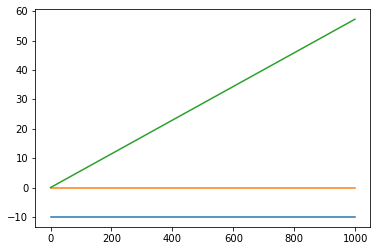

In [60]:
poly_order = 3
threshold = 0.1

t = np.arange(0, dt*1000, dt)
u_g_train = np.concatenate((u_g[:,:3], t[:,np.newaxis]), axis=1)

fouriermodel_g = ps.SINDy(
    optimizer=ps.STLSQ(threshold=threshold, max_iter=1000, fit_intercept=False),
    feature_library=ps.FourierLibrary(n_frequencies=3),
    feature_names=['u1', 'u2', 'u3', 't']
)

fouriermodel_g.fit(u_g_train, t)
fouriermodel_g.print()

u1_g_sim, u2_g_sim, u3_g_sim, t_g_sim = fouriermodel_g.simulate([-10, 0, 0, 0], t).T
plt.plot(u1_g_sim)
plt.plot(u2_g_sim)
plt.plot(u3_g_sim)

## Also crap

## Run SINDy on simple sin and cosine system just to see how it works

In [61]:
x1 = np.sin(t)
x2 = np.cos(t)
x3 = np.cos(2*t)
x4 = np.sin(0.5*t)

/Users/nate/opt/anaconda3/envs/pysindy/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=9.4303e-47): result may not be accurate.
  overwrite_a=True).T
/Users/nate/opt/anaconda3/envs/pysindy/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=9.4303e-47): result may not be accurate.
  overwrite_a=True).T
/Users/nate/opt/anaconda3/envs/pysindy/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=9.4303e-47): result may not be accurate.
  overwrite_a=True).T
/Users/nate/opt/anaconda3/envs/pysindy/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=9.4303e-47): result may not be accurate.
  overwrite_a=True).T
/Users/nate/opt/anaconda3/envs/pysindy/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=9.4303e-

x1' = 1.000 cos(1 t)
x2' = -1.000 sin(1 t)
x3' = -1.997 sin(2 t)
x4' = 0.500 cos(1/2 t)
t' = 1.000


<function matplotlib.pyplot.show>

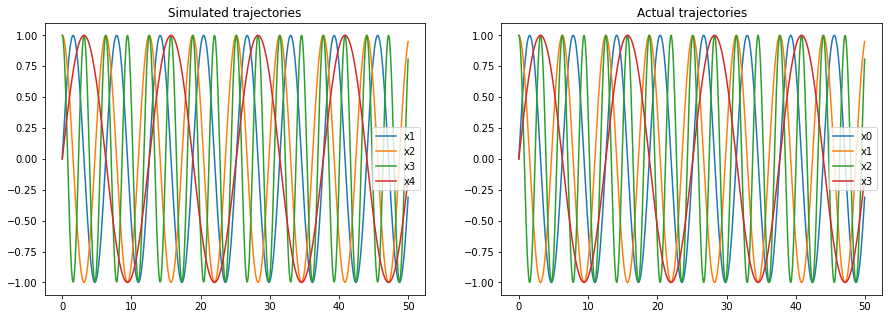

In [62]:

threshold = 0.1

train = np.vstack((x1,x2,x3,x4,t)).T


functions = [
    lambda x : np.exp(x), 
    lambda x : np.sin(1/2 * x),
    lambda x : np.cos(1/2 * x),
    lambda x : np.sin(1/3 * x),
    lambda x : np.cos(1/3 * x),
]
function_names = [
    lambda x :  'exp({})'.format(x),
    lambda x :  'sin(1/2 {})'.format(x),
    lambda x :  'cos(1/2 {})'.format(x),
    lambda x :  'sin(1/3 {})'.format(x),
    lambda x :  'cos(1/3 {})'.format(x),
]

customlib = ps.CustomLibrary(library_functions=functions, function_names=function_names)
model = ps.SINDy(
    optimizer=ps.STLSQ(threshold=threshold, max_iter=1000, fit_intercept=True),
    feature_library=ps.FourierLibrary(n_frequencies=2)+customlib,
    feature_names=['x1', 'x2', 'x3', 'x4', 't']
)

model.fit(train, t)
model.print()

x1_sim, x2_sim, x3_sim, x4_sim, t_sim = model.simulate([0,1,1,0,0], t).T

f, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].plot(t, x1_sim, label='x1')
ax[0].plot(t, x2_sim, label='x2')
ax[0].plot(t, x3_sim, label='x3')
ax[0].plot(t, x4_sim, label='x4')
ax[0].legend()
ax[0].set_title('Simulated trajectories')

for i,p in enumerate([x1,x2,x3,x4]):
    ax[1].plot(t, p, label='x{}'.format(i))
ax[1].legend()
ax[1].set_title('Actual trajectories')

plt.show

## With the correct terms, it actually fits the system

Had to add a custom library that had the cos(1/2 x) term, otherwise it wouldn't fit the data

### Try to fit the wave eqn POD with custom library functions

This was fit iteratively by inspection.

0.00019793603275802135


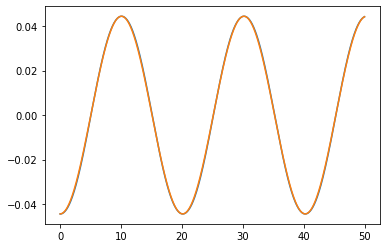

In [63]:
# Actual POD bases - the 0 base has a wavenumber of 1/3.2=0.3125

plt.plot(t, u_g_train[:,0])
plt.plot(t, -0.0444*np.cos(1/3.2*t))

sqerror = ((u_g_train[:,0] - (-0.0444*np.cos(1/3.2*t)))**2).sum()
print(sqerror)

## calc derivative of the above relation

$\frac{d}{dt}0.0444 * cos(1/3.2 * t) = -1/3.2 * 0.444 * sin(1/3.2 *t) = 0.013875*sin(1/3.2*t)$

## Digression to see if we can use Pytorch to fit the first mode with a cosine

In [64]:
import torch

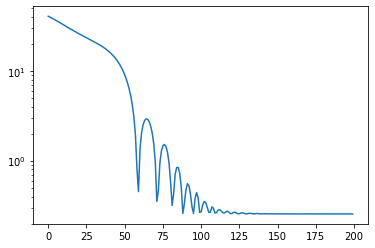

In [65]:
a = torch.tensor(-0.0544, dtype=torch.float, requires_grad=True)
n = torch.tensor(1/4, dtype=torch.float, requires_grad=True)

ugtrain = torch.tensor(u_g_train[:,0])
ttorch = torch.tensor(t)

criterion = torch.nn.L1Loss(reduction='sum')

def fnc(ts):
    return a*torch.cos(n*ts)

optimizer = torch.optim.Adam([a,n], 0.001)

losses =[]

for i in range(200):
    optimizer.zero_grad()
    loss = criterion(fnc(ttorch), ugtrain)
    loss.backward(retain_graph=True)
    losses.append(loss.item())
    optimizer.step()
    
plt.semilogy(losses)

In [66]:
a, n

(tensor(-0.0449, requires_grad=True), tensor(0.3124, requires_grad=True))

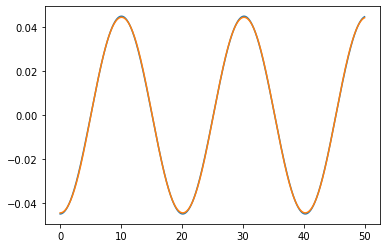

In [31]:
plt.plot(t,fnc(ttorch).detach().numpy())
plt.plot(t, ugtrain.detach().numpy())

### This took quite a few tries, changing the starting values of $a$ and $n$, to get it to fit properly

This is because the loss function has a lot of local minima, dependent on the initial values of $a$ and $n$.

Would be fun to plot the loss function as vs values of $a$ and $n$ to show all of the local mininma

## Custom function library

Contains the function of the dominant coordinate and a distractor

In [67]:
functions = [
    #lambda x: np.cos(1/2 * x), 
    #lambda x: np.sin(1/2 * x),
    lambda x: np.cos(1/3 * x), 
    lambda x: np.sin(1/3 * x),
    lambda x: np.cos(1/3.2 * x), 
    lambda x: np.sin(1/3.2 * x),
    #lambda x: np.cos(1/4 * x), 
    #lambda x: np.sin(1/4 * x),
    #lambda x: np.cos(1/5 * x), 
    #lambda x: np.sin(1/5 * x),
]
function_names = [
    #lambda x: 'cos(1/2 {})'.format(a,x),
    #lambda x: 'sin(1/2 {})'.format(a,x),
    lambda x: 'cos(1/3 {})'.format(a,x),
    lambda x: 'sin(1/3 {})'.format(a,x),
    lambda x: 'cos(1/3.2 {})'.format(a,x),
    lambda x: 'sin(1/3.2 {})'.format(a,x),
    #lambda x: 'cos(1/4 {})'.format(a,x),
    #lambda x: 'sin(1/4 {})'.format(a,x),
    #lambda x: 'cos(1/5 {})'.format(a,x),
    #lambda x: 'sin(1/5 {})'.format(a,x),
]

FractionFourierLib = ps.CustomLibrary(library_functions=functions, function_names=function_names)

/Users/nate/opt/anaconda3/envs/pysindy/lib/python3.7/site-packages/pysindy/optimizers/stlsq.py:153: UserWarning: Sparsity parameter is too big (0.05) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/nate/opt/anaconda3/envs/pysindy/lib/python3.7/site-packages/pysindy/optimizers/stlsq.py:153: UserWarning: Sparsity parameter is too big (0.05) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/nate/opt/anaconda3/envs/pysindy/lib/python3.7/site-packages/pysindy/optimizers/stlsq.py:153: UserWarning: Sparsity parameter is too big (0.05) and eliminated all coefficients
  "coefficients".format(self.threshold)


ug0' = 0.002
ug1' = 11043.827 cos(2 ug0) + -4913.874 cos(3 ug0) + 0.336
ug2' = -25089.077 cos(2 ug0) + 2556.159 cos(2 ug1) + 11158.946 cos(3 ug0) + -1135.288 cos(3 ug1) + -0.202
t' = 1.000


/Users/nate/opt/anaconda3/envs/pysindy/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


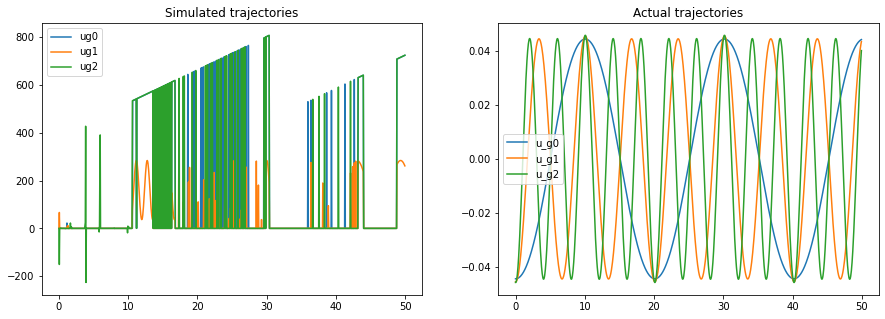

In [68]:

threshold = 0.05

t = np.arange(0, dt*1000, dt)
u_g_train = np.concatenate((u_g[:,:3], t[:,np.newaxis]), axis=1)

feature_libs = ps.FourierLibrary(n_frequencies=3) + FractionFourierLib +ps.PolynomialLibrary(0)
fouriermodel_g = ps.SINDy(
    optimizer=ps.STLSQ(threshold=threshold, max_iter=1000, fit_intercept=True),
    feature_library=feature_libs,
    feature_names=['ug0', 'ug1', 'ug2', 't']
)

fouriermodel_g.fit(u_g_train, t)
fouriermodel_g.print()

ug1_sim, ug2_sim, ug3_sim, t_sim = fouriermodel_g.simulate([u_g[0,0], u_g[0,1], u_g[0,2], 0],t).T

f, ax = plt.subplots(1,2, figsize=(15,5))

for i,p in enumerate([ug1_sim, ug2_sim, ug3_sim]):
    ax[0].plot(t, p, label='ug{}'.format(i))
ax[0].legend()
ax[0].set_title('Simulated trajectories')

for i in range(3):
    ax[1].plot(t, u_g[:,i], label='u_g{}'.format(i))
ax[1].legend()
ax[1].set_title('Actual trajectories')

plt.show()

## Try the Guassian init cond

In [70]:
u, s, vt = np.linalg.svd(gaussian)

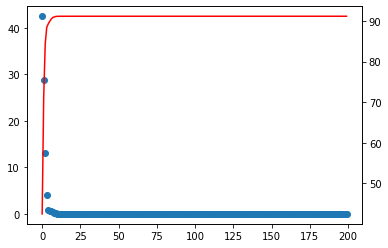

In [71]:
f,ax = plt.subplots(1,1)
ax.plot(s, 'o')
ax2 = ax.twinx()
ax2.plot(s.cumsum(), 'r')

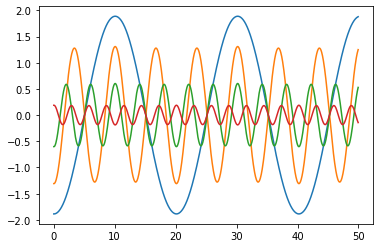

In [42]:
plt.plot(t, u[:,:4]*s[:4])

/Users/nate/opt/anaconda3/envs/pysindy/lib/python3.7/site-packages/pysindy/optimizers/stlsq.py:153: UserWarning: Sparsity parameter is too big (0.1) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/nate/opt/anaconda3/envs/pysindy/lib/python3.7/site-packages/pysindy/optimizers/stlsq.py:153: UserWarning: Sparsity parameter is too big (0.1) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/nate/opt/anaconda3/envs/pysindy/lib/python3.7/site-packages/pysindy/optimizers/stlsq.py:153: UserWarning: Sparsity parameter is too big (0.1) and eliminated all coefficients
  "coefficients".format(self.threshold)


ug0' = 0.000
ug1' = 0.000
ug2' = -1.353 cos(3 ug0) + 1.355 cos(3 ug1)
ug3' = 1.908 cos(3 ug1) + -1.910 cos(3 ug2)
t' = 0.000


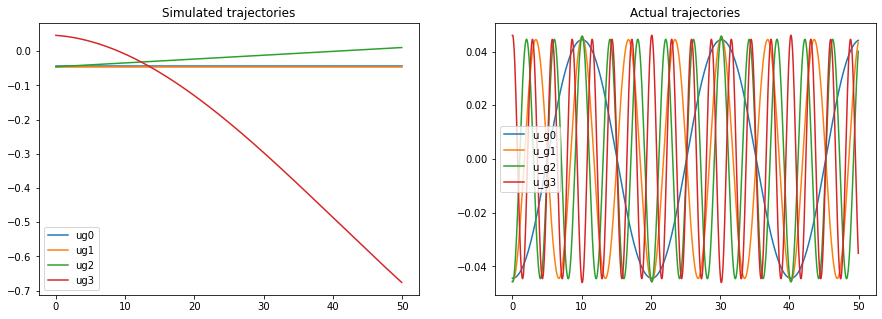

In [43]:
threshold = 0.1

ug_train = np.concatenate((u_g[:,:4], t[:,np.newaxis]), axis=1)

fouriermodel = ps.SINDy(
    optimizer=ps.STLSQ(threshold=threshold, max_iter=1000, fit_intercept=False),
    feature_library=feature_libs,
    feature_names=['ug0', 'ug1', 'ug2', 'ug3', 't']
)

fouriermodel.fit(ug_train, t)
fouriermodel.print()

ug1_sim, ug2_sim, ug3_sim, ug4_sim, t_sim = fouriermodel.simulate([u[0,0], u[0,1], u[0,2], u[0,3],0],t).T

f, ax = plt.subplots(1,2, figsize=(15,5))

for i,p in enumerate([ug1_sim, ug2_sim, ug3_sim, ug4_sim]):
    ax[0].plot(t, p, label='ug{}'.format(i))
ax[0].legend()
ax[0].set_title('Simulated trajectories')

for i in range(4):
    ax[1].plot(t, u_g[:,i], label='u_g{}'.format(i))
ax[1].legend()
ax[1].set_title('Actual trajectories')

plt.show()